# Cirrhosis Prediction Dataset Analysis
This is notebook performs a blind analysis to find the most predictive factors of cirrhosis staging by employing exploratory data analysis and supervised learning.

We're going to take the following approach:
1. Problem definition
2. Data
3. Evaluation
4. Features
5. Modelling
6. Experimentation

## 1. Problem Definition
In a statement,
> Given clinical parameters about a patient, can we predict whether the person has cirrhosis or not and which satge?

## 2. Data
The dataset for this analysis is obtained from Kaggle: https://www.kaggle.com/datasets/fedesoriano/cirrhosis-prediction-dataset

Cirrhosis is a late stage of scarring (fibrosis) of the liver caused by many forms of liver diseases and conditions, such as hepatitis and chronic alcoholism. The following data contains the information collected from the Mayo Clinic trial in primary biliary cirrhosis (PBC) of the liver conducted between 1974 and 1984. A description of the clinical background for the trial and the covariates recorded here is in Chapter 0, especially Section 0.2 of Fleming and Harrington, Counting
Processes and Survival Analysis, Wiley, 1991. A more extended discussion can be found in Dickson, et al., Hepatology 10:1-7 (1989) and in Markus, et al., N Eng J of Med 320:1709-13 (1989).

A total of 424 PBC patients, referred to Mayo Clinic during that ten-year interval, met eligibility criteria for the randomized placebo-controlled trial of the drug D-penicillamine. The first 312 cases in the dataset participated in the randomized trial and contain largely complete data. The additional 112 cases did not participate in the clinical trial but consented to have basic measurements recorded and to be followed for survival. Six of those cases were lost to follow-up shortly after diagnosis, so the data here are on an additional 106 cases as well as the 312 randomized participants.

## 3. Evaluation
> We want to build a model that can accurately classify Cirrhosis stages with more than 95% precision. 

## 4. Features
1) ID: unique identifier
2) N_Days: number of days between registration and the earlier of death, transplantation, or study analysis time in July 1986
3) Status: status of the patient C (censored), CL (censored due to liver tx), or D (death)
4) Drug: type of drug D-penicillamine or placebo
5) Age: age in [days]
6) Sex: M (male) or F (female)
7) Ascites: presence of ascites N (No) or Y (Yes)
8) Hepatomegaly: presence of hepatomegaly N (No) or Y (Yes)
9) Spiders: presence of spiders N (No) or Y (Yes)
10) Edema: presence of edema N (no edema and no diuretic therapy for edema), S (edema present without diuretics, or edema resolved by diuretics), or Y (edema despite diuretic therapy)
11) Bilirubin: serum bilirubin in [mg/dl]
12) Cholesterol: serum cholesterol in [mg/dl]
13) Albumin: albumin in [gm/dl]
14) Copper: urine copper in [ug/day]
15) Alk_Phos: alkaline phosphatase in [U/liter]
16) SGOT: SGOT in [U/ml]
17) Triglycerides: triglicerides in [mg/dl]
18) Platelets: platelets per cubic [ml/1000]
19) Prothrombin: prothrombin time in seconds [s]
20) Stage: histologic stage of disease (1, 2, 3, or 4)

## Preparing the Tools
We are going to use pandas for loading and exploring the data, matplotlib and seaborn for visualization, and sklearn to build and train machine learning models

In [1]:
# Import all the tools we need

# Regular EDA (exploratory data analysis) and plotting libraries
# supress Future warnings
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    plot_roc_curve,
    precision_score,
    recall_score,
)

# Model Evaluations
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    train_test_split,
)

# we want our plots to appear inside the notebook
%matplotlib inline


warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore", category=FutureWarning)

## Helper Functions

In [2]:
# this plots a Box plot and histogram for a numeric variable
def num_plot(data, col):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    sns.histplot(data=data, x=col, kde=True, ax=ax[0])
    sns.boxplot(data=data, x=col, ax=ax[1])
    ax[0].set_title(f"{col} Distribution Histogram")
    ax[1].set_title(f"{col} Distribution Boxplot")

    plt.show()


# this plots histogram and density plots that show variable of any numeric variable with the target classes
def histplot(data, target_col, feature_col):
    # Distribution of feature by target
    fig, ax = plt.subplots(figsize=(12, 6))

    for class_ in data[target_col].unique():
        sub_data = data[data[target_col] == class_]
        sns.distplot(sub_data[feature_col], label=class_)
    ax.legend()
    ax.set_title(f"{feature_col} Distribution")


# this plots a bar chart and pie chart for any categorical variable
def plotPieANDBar(data, categorical_col, target_col, top_colors):

    target_order = data[data[target_col].notna()][target_col].unique()
    feature_order = data[data[categorical_col].notna()][categorical_col].unique()
    p_colors = top_colors[: len(target_order)]
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    data[categorical_col].value_counts().plot(
        kind="pie",
        labels=feature_order,
        colors=p_colors,
        explode=[0.05] * len(feature_order),
        autopct="%1.1f%%",
        ax=ax[0],
        shadow=True,
    )
    ax[0].set_title(f"{categorical_col} Pie Chart")
    ax[0].set_ylabel("")

    ax[1] = pd.crosstab(data_raw[target_col], data_raw[categorical_col]).plot(
        kind="bar", color=p_colors, ax=ax[1]
    )

    plt.title(f"{case_study} Frequency for {categorical_col}")
    plt.xlabel(f"{categorical_col}")
    plt.ylabel("Amount")
    plt.legend()
    plt.xticks(rotation=0)
    plt.show()


# this plots scatter plots between 2 numeric variables and shows patterns of how thwy each affect the target variable
def scatterplots(data, feature_col1, feature_col2, target_col, top_colors):
    # Create another figure
    plt.figure(figsize=(12, 6))

    axes = []
    target_classes = data[target_col].unique()
    colors = top_colors[: len(target_classes)]
    for i, class_ in enumerate(target_classes):
        axes.append(
            plt.scatter(
                data[feature_col1][data[target_col] == class_],
                data[feature_col2][data[target_col] == class_],
                c=colors[i],
            )
        )

    # Add some helpful info
    plt.title(f"{case_study} in function of {feature_col1} and {feature_col2}")
    plt.xlabel(f"{feature_col1}")
    plt.ylabel(f"{feature_col2}")
    plt.legend(axes, target_classes)


# plots a 2 component PCA
def plotPCA2(xpca, top_colors, markers, target_classes, labels):
    PC1 = 0
    PC2 = 1
    plt.figure(figsize=(12, 6))
    colors = top_colors[: len(target_classes)]
    axes = []

    for i, class_ in enumerate(target_classes):
        axes.append(
            plt.scatter(
                xpca[labels == class_][:, PC1],
                xpca[labels == class_][:, PC2],
                c=colors[i],
                marker=markers[i],
            )
        )

    # Add some helpful info
    plt.title(f"2 component PCA Results for {case_study} Dataset")
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.legend(axes, target_classes);

## Load Data

In [3]:
data = pd.read_csv("cirrhosis.csv")
data.drop("ID", axis=1, inplace=True)
data.head()

N_Days Status             Drug    Age Sex Ascites Hepatomegaly Spiders  \
0     400      D  D-penicillamine  21464   F       Y            Y       Y   
1    4500      C  D-penicillamine  20617   F       N            Y       Y   
2    1012      D  D-penicillamine  25594   M       N            N       N   
3    1925      D  D-penicillamine  19994   F       N            Y       Y   
4    1504     CL          Placebo  13918   F       N            Y       Y   

  Edema  Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  \
0     Y       14.5        261.0     2.60   156.0    1718.0  137.95   
1     N        1.1        302.0     4.14    54.0    7394.8  113.52   
2     S        1.4        176.0     3.48   210.0     516.0   96.10   
3     S        1.8        244.0     2.54    64.0    6121.8   60.63   
4     N        3.4        279.0     3.53   143.0     671.0  113.15   

   Tryglicerides  Platelets  Prothrombin  Stage  
0          172.0      190.0         12.2    4.0  
1           88.0      221.0         10.6    3.0  
2           55.0      151.0         12.0    4.0  
3           92.0      183.0         10.3    4.0  
4           72.0      136.0         10.9    3.0

In [4]:
data.tail()

N_Days Status Drug    Age Sex Ascites Hepatomegaly Spiders Edema  \
413     681      D  NaN  24472   F     NaN          NaN     NaN     N   
414    1103      C  NaN  14245   F     NaN          NaN     NaN     N   
415    1055      C  NaN  20819   F     NaN          NaN     NaN     N   
416     691      C  NaN  21185   F     NaN          NaN     NaN     N   
417     976      C  NaN  19358   F     NaN          NaN     NaN     N   

     Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos  SGOT  Tryglicerides  \
413        1.2          NaN     2.96     NaN       NaN   NaN            NaN   
414        0.9          NaN     3.83     NaN       NaN   NaN            NaN   
415        1.6          NaN     3.42     NaN       NaN   NaN            NaN   
416        0.8          NaN     3.75     NaN       NaN   NaN            NaN   
417        0.7          NaN     3.29     NaN       NaN   NaN            NaN   

     Platelets  Prothrombin  Stage  
413      174.0         10.9    3.0  
414      180.0         11.2    4.0  
415      143.0          9.9    3.0  
416      269.0         10.4    3.0  
417      350.0         10.6    4.0

In [5]:
# check data dimensions
data.shape

(418, 19)

## Data Exploration (exploratory data analysis or EDA)
We will try to learn more about our data by answering these questions.
1. What question(s) are you trying to solve?
2. What kind of data do we have and how do we treat different types?
3. What's missing from the data and how do you deal with it?
4. Where are the outliers and why should you care about them?
5. Is Is any feature correlated with the target?
6. Are there any patterns in the data?
7. How can you add, change or remove features to get more out of your data?

### Setting some global Variables

In [6]:
# colors to use for visualization
top_colors = [
    "salmon",
    "lightblue",
    "orange",
    "blue",
    "green",
    "navy",
    "gray",
    "red",
    "yellow",
]
# the target label on the dataframe
target_col = "Stage"
# the condition or situation being studied
case_study = "Cirrhosis"
# we will save the original dataframe for later use of catgorical labels
# first remove rows with missing labels
data = data[data[target_col].notna()]
data_raw = data.copy()
# target column
labels = data[target_col]
# markers to use for target classes
markers = ["o", "+", "*", "s", "x", "^"]

In [7]:
# Let's find out how many of each class there
data[target_col].value_counts()

3.0    155
4.0    144
2.0     92
1.0     21
Name: Stage, dtype: int64

In [8]:
data.shape, data_raw.shape

((412, 19), (412, 19))

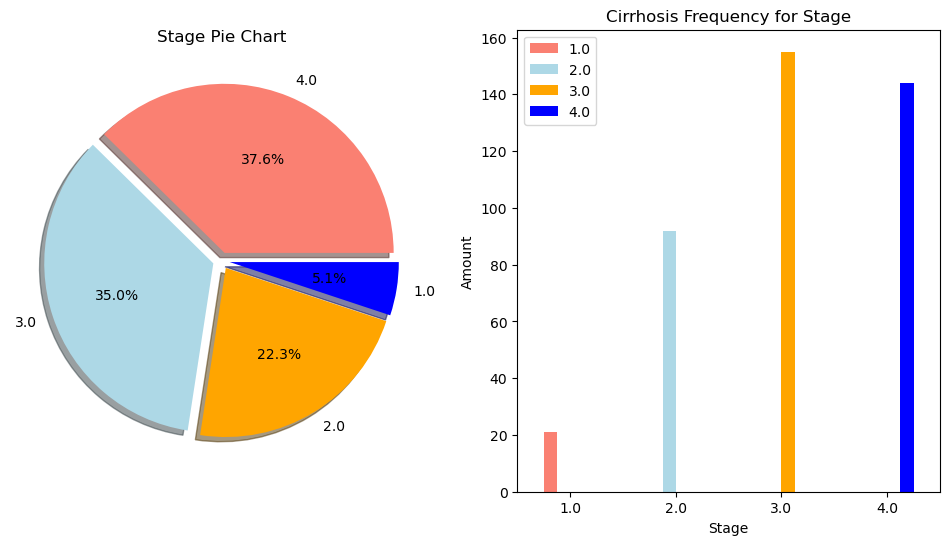

In [9]:
plotPieANDBar(data_raw, target_col, target_col, top_colors)

**Observation:**   
* The dataset suffers from class imbalance.
* There is far more data for the advanced stages of the disease than the earlier stages. This might be explained by the fact that earlier stages are not easy to detect. 
* We might have to penalize the lower classes when computing the loss function. More so, we might have to create artificial data for stage 1 which has very little data.

In [10]:
# check the data types of each feature
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412 entries, 0 to 417
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         412 non-null    int64  
 1   Status         412 non-null    object 
 2   Drug           312 non-null    object 
 3   Age            412 non-null    int64  
 4   Sex            412 non-null    object 
 5   Ascites        312 non-null    object 
 6   Hepatomegaly   312 non-null    object 
 7   Spiders        312 non-null    object 
 8   Edema          412 non-null    object 
 9   Bilirubin      412 non-null    float64
 10  Cholesterol    284 non-null    float64
 11  Albumin        412 non-null    float64
 12  Copper         310 non-null    float64
 13  Alk_Phos       312 non-null    float64
 14  SGOT           312 non-null    float64
 15  Tryglicerides  282 non-null    float64
 16  Platelets      401 non-null    float64
 17  Prothrombin    410 non-null    float64
 18  Stage     

**Observation:**   
* The dataset contians many categorical variables and numeric variables.
* Some columns contain some missing data.
* Since the dataset is limited, we will have to fill in the missing values

In [11]:
# get a statistical summary of our data
data.describe()

N_Days           Age   Bilirubin  Cholesterol     Albumin  \
count   412.000000    412.000000  412.000000   284.000000  412.000000   
mean   1916.837379  18498.286408    3.227670   369.510563    3.500073   
std    1099.941147   3823.705746    4.429421   231.944545    0.423948   
min      41.000000   9598.000000    0.300000   120.000000    1.960000   
25%    1094.250000  15609.250000    0.800000   249.500000    3.247500   
50%    1713.500000  18628.000000    1.400000   309.500000    3.530000   
75%    2610.500000  21200.500000    3.400000   400.000000    3.782500   
max    4795.000000  28650.000000   28.000000  1775.000000    4.640000   

           Copper      Alk_Phos        SGOT  Tryglicerides   Platelets  \
count  310.000000    312.000000  312.000000     282.000000  401.000000   
mean    97.648387   1982.655769  122.556346     124.702128  256.102244   
std     85.613920   2140.388824   56.699525      65.148639   95.750598   
min      4.000000    289.000000   26.350000      33.000000   62.000000   
25%     41.250000    871.500000   80.600000      84.250000  189.000000   
50%     73.000000   1259.000000  114.700000     108.000000  249.000000   
75%    123.000000   1980.000000  151.900000     151.000000  318.000000   
max    588.000000  13862.400000  457.250000     598.000000  563.000000   

       Prothrombin       Stage  
count   410.000000  412.000000  
mean     10.733415    3.024272  
std       1.026557    0.882042  
min       9.000000    1.000000  
25%      10.000000    2.000000  
50%      10.600000    3.000000  
75%      11.100000    4.000000  
max      18.000000    4.000000

## Encode Categorical Varibales

In [12]:
# categorical columns
catCols = data.select_dtypes("object").columns
catCols

Index(['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object')

In [13]:
### convert all columns that contain categorical variables to the pandas categorical
### object which is recognisable in sklearn

for column in catCols:
    data[column] = data[column].astype("category").cat.codes + 1

data.dtypes

N_Days             int64
Status              int8
Drug                int8
Age                int64
Sex                 int8
Ascites             int8
Hepatomegaly        int8
Spiders             int8
Edema               int8
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
Stage            float64
dtype: object

In [14]:
data

N_Days  Status  Drug    Age  Sex  Ascites  Hepatomegaly  Spiders  Edema  \
0       400       3     1  21464    1        2             2        2      3   
1      4500       1     1  20617    1        1             2        2      1   
2      1012       3     1  25594    2        1             1        1      2   
3      1925       3     1  19994    1        1             2        2      2   
4      1504       2     2  13918    1        1             2        2      1   
..      ...     ...   ...    ...  ...      ...           ...      ...    ...   
413     681       3     0  24472    1        0             0        0      1   
414    1103       1     0  14245    1        0             0        0      1   
415    1055       1     0  20819    1        0             0        0      1   
416     691       1     0  21185    1        0             0        0      1   
417     976       1     0  19358    1        0             0        0      1   

     Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  Tryglicerides  \
0         14.5        261.0     2.60   156.0    1718.0  137.95          172.0   
1          1.1        302.0     4.14    54.0    7394.8  113.52           88.0   
2          1.4        176.0     3.48   210.0     516.0   96.10           55.0   
3          1.8        244.0     2.54    64.0    6121.8   60.63           92.0   
4          3.4        279.0     3.53   143.0     671.0  113.15           72.0   
..         ...          ...      ...     ...       ...     ...            ...   
413        1.2          NaN     2.96     NaN       NaN     NaN            NaN   
414        0.9          NaN     3.83     NaN       NaN     NaN            NaN   
415        1.6          NaN     3.42     NaN       NaN     NaN            NaN   
416        0.8          NaN     3.75     NaN       NaN     NaN            NaN   
417        0.7          NaN     3.29     NaN       NaN     NaN            NaN   

     Platelets  Prothrombin  Stage  
0        190.0         12.2    4.0  
1        221.0         10.6    3.0  
2        151.0         12.0    4.0  
3        183.0         10.3    4.0  
4        136.0         10.9    3.0  
..         ...          ...    ...  
413      174.0         10.9    3.0  
414      180.0         11.2    4.0  
415      143.0          9.9    3.0  
416      269.0         10.4    3.0  
417      350.0         10.6    4.0  

[412 rows x 19 columns]

In [15]:
data.head()

N_Days  Status  Drug    Age  Sex  Ascites  Hepatomegaly  Spiders  Edema  \
0     400       3     1  21464    1        2             2        2      3   
1    4500       1     1  20617    1        1             2        2      1   
2    1012       3     1  25594    2        1             1        1      2   
3    1925       3     1  19994    1        1             2        2      2   
4    1504       2     2  13918    1        1             2        2      1   

   Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  Tryglicerides  \
0       14.5        261.0     2.60   156.0    1718.0  137.95          172.0   
1        1.1        302.0     4.14    54.0    7394.8  113.52           88.0   
2        1.4        176.0     3.48   210.0     516.0   96.10           55.0   
3        1.8        244.0     2.54    64.0    6121.8   60.63           92.0   
4        3.4        279.0     3.53   143.0     671.0  113.15           72.0   

   Platelets  Prothrombin  Stage  
0      190.0         12.2    4.0  
1      221.0         10.6    3.0  
2      151.0         12.0    4.0  
3      183.0         10.3    4.0  
4      136.0         10.9    3.0

## Analysizng Categorical Features

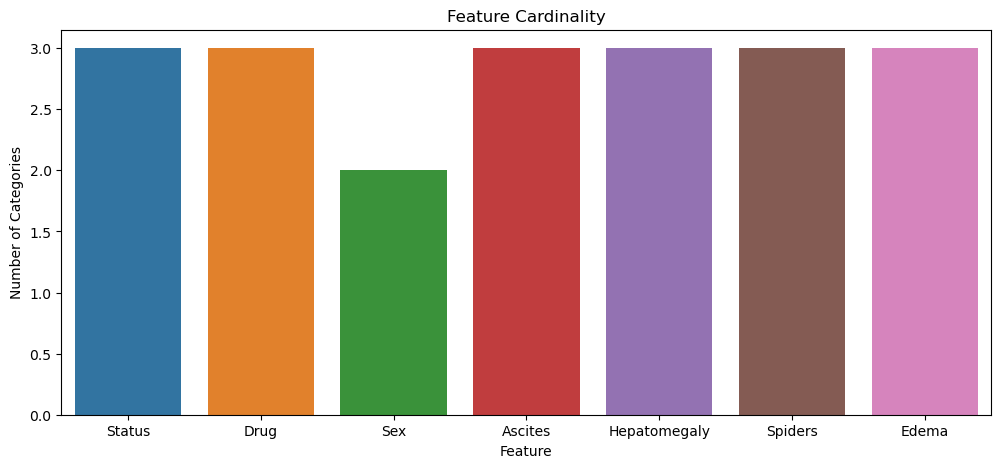

In [16]:
# Look at cadinality of the categorical columns
cards = [len(data[col].unique()) for col in catCols]

fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x=catCols, y=cards)
ax.set_xlabel("Feature")
ax.set_ylabel("Number of Categories")
ax.set_title("Feature Cardinality");

### Sex

In [17]:
feature_col = "Sex"
data_raw[feature_col].value_counts()

F    368
M     44
Name: Sex, dtype: int64

In [18]:
# Compare target column with sex column
pd.crosstab(data_raw[target_col], data_raw[feature_col])

Sex      F   M
Stage         
1.0     18   3
2.0     84   8
3.0    139  16
4.0    127  17

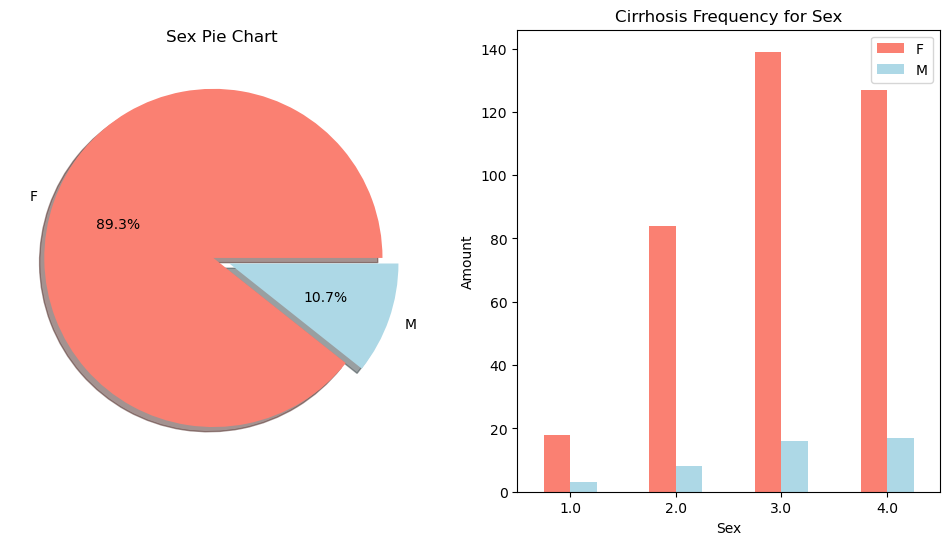

In [19]:
plotPieANDBar(data_raw, feature_col, target_col, top_colors)

**Observation**  
* Irregardless of the disease stage, the females seem to suffer more from this disease than the males. This is quite unusual as it is actually the other way round (Giard, J.-M., & Terrault, N. A. (2016). Women with Cirrhosis. Gastroenterology Clinics of North America, 45(2), 345–358. [https://doi.org/10.1016/j.gtc.2016.02.010
‌](https://doi.org/10.1016/j.gtc.2016.02.010)). 
* Perhaps the sampling of the dataset was biased towards the feminine gender.
* Also, the dataset was collected between 1974 and 1984. It could be that women suffered more from Cirrhosis during that period. 
* Another explanation to this trend is that, men dont usually give consent to such studies and that is why the study included more women than men. 
* It is actually hard to draw solid conclusions based on this plot.


## Analyzing Numeric Variables

In [20]:
# numerical columns
numeric_columns = list(data_raw.select_dtypes(exclude=["object"]).columns)
numeric_columns

['N_Days',
 'Age',
 'Bilirubin',
 'Cholesterol',
 'Albumin',
 'Copper',
 'Alk_Phos',
 'SGOT',
 'Tryglicerides',
 'Platelets',
 'Prothrombin',
 'Stage']

### Age

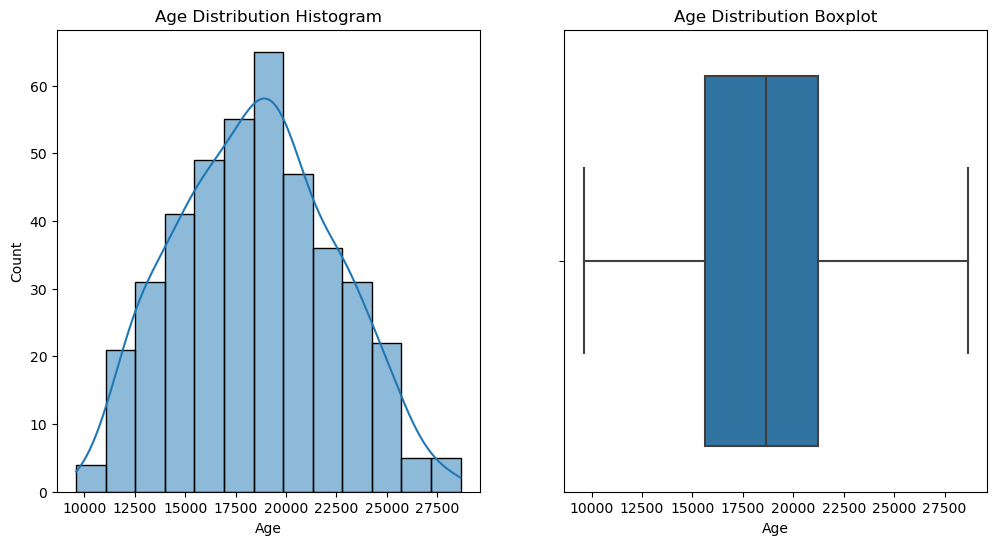

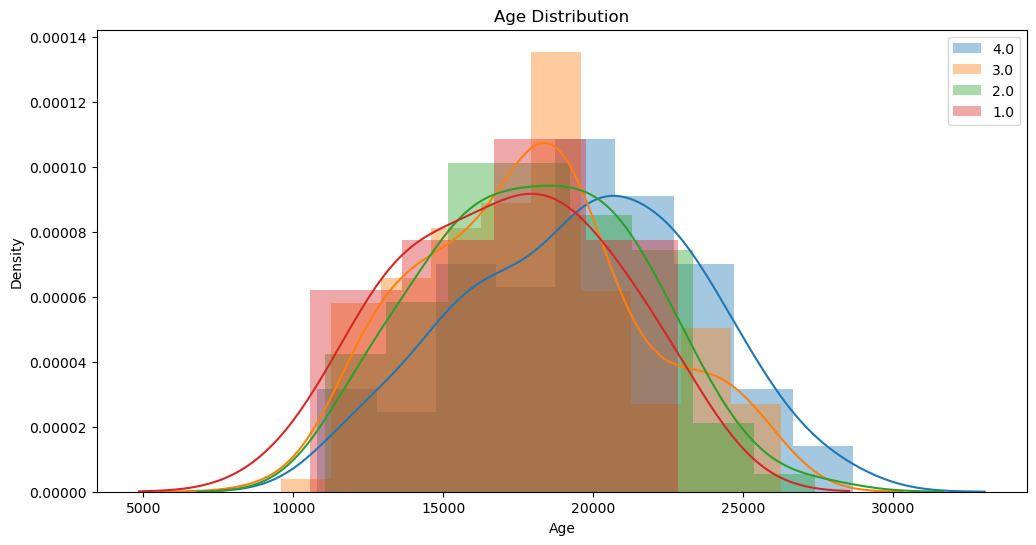

In [21]:
feature_col = "Age"
num_plot(data, feature_col)
histplot(data_raw, target_col, feature_col)

**Observation**
* The plots show that the dataset has a normal distribution with respect to age. 
* The density plots even shows that the normal distribution is valid for all the disease classes.

## Searching for Patterns Using Scatter Plots
Here, we will perform multivariate analysis of our dataset for some features.

#### Age vs. Max Heart Rate for Heart Disease

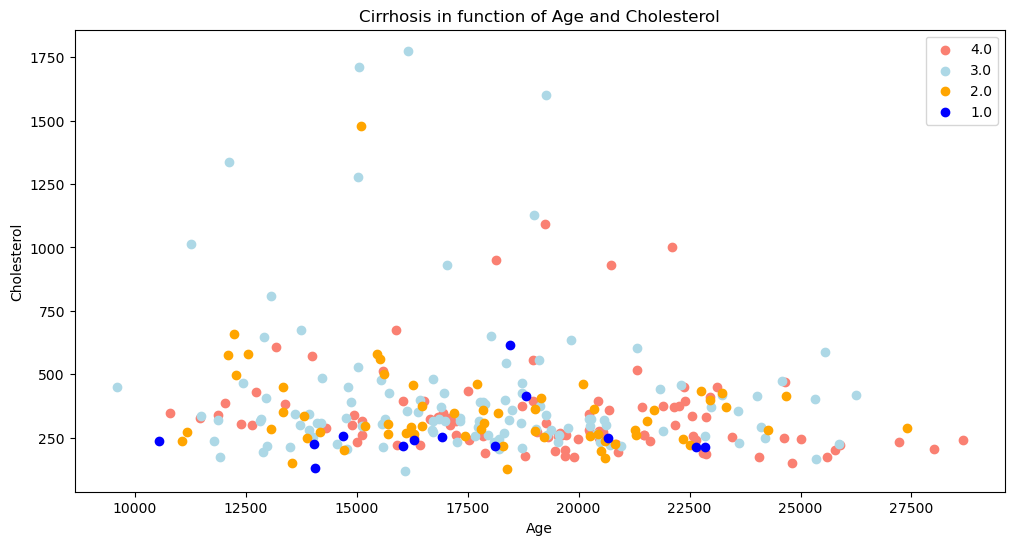

In [22]:
scatterplots(data_raw, "Age", "Cholesterol", target_col, top_colors)

**Observation**   
* A clear pattern that can be observed in this plot is that the cholesterol levels are low in the stage 1 cases irrespective of the age. 
* Also, Cholesterol levels above 750 are more likely stage 3 and 4 of the disease.  

#### Prothrombin vs Platelets

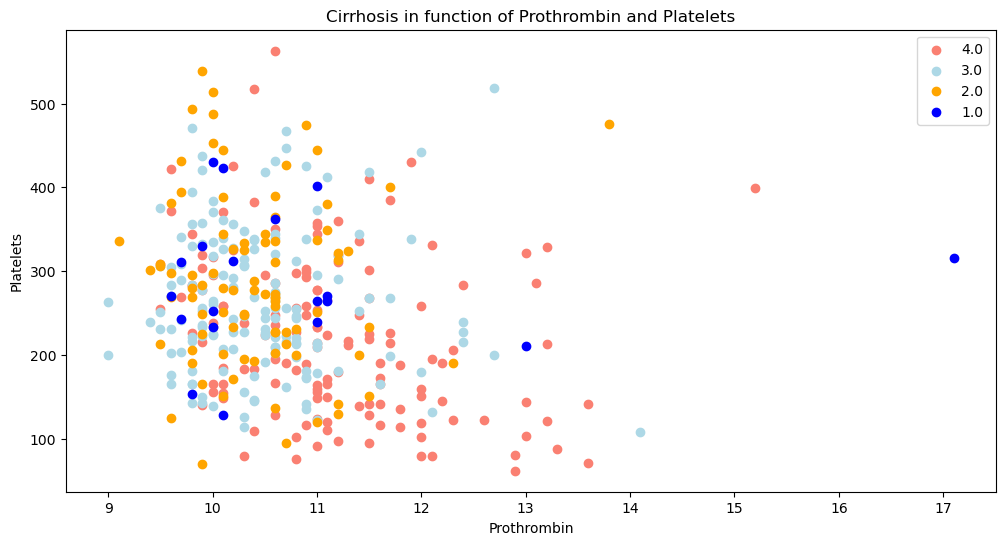

In [23]:
scatterplots(data_raw, "Prothrombin", "Platelets", target_col, top_colors)

**Observation**   
* Cases in the lower right quadrant (low platelets levels and high prothrombin levels) have a high probability for stage 4 Cirrhosis.
* This makes sense because platlets produce clotting factors that could stop cirrhosis. Also. high Prothrombin levels slow down blood clotting and therefore promote cirrhosis.

#### Using PCA to visualise all features
With PCA, we can visualize the entire data in low dimensions while retaining the maximum information possible.

In [24]:
from sklearn.impute import SimpleImputer

# build an imputer with mean imputation
SI = SimpleImputer(strategy="mean")

# get numeric columns
data_numeric = data.drop(target_col, axis=1).select_dtypes(exclude=["int8"])

# impute numeric data
data_numeric = pd.DataFrame(
    SI.fit_transform(data_numeric), columns=data_numeric.columns
)
# update data
for column in data_numeric.columns:
    data[column] = data_numeric[column]

# build an imputer with median imputation for categorical variables
SI = SimpleImputer(strategy="median")

# get categorical columns
data_categorical = data.drop(target_col, axis=1).select_dtypes(["int8"])

# impute categorical data
data_categorical = pd.DataFrame(
    SI.fit_transform(data_categorical), columns=data_categorical.columns
)
# update data
for column in data_categorical.columns:
    data[column] = data_categorical[column]

data.dropna(axis=0, inplace=True)
data_raw = data_raw.loc[data.index]
data = data.reset_index()
data.drop("index", axis=1, inplace=True)

In [25]:
from sklearn.preprocessing import StandardScaler

scaled = StandardScaler()
scaled.fit(data)
scaled_data = scaled.transform(data)

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(scaled_data)
xpca = pca.transform(scaled_data)

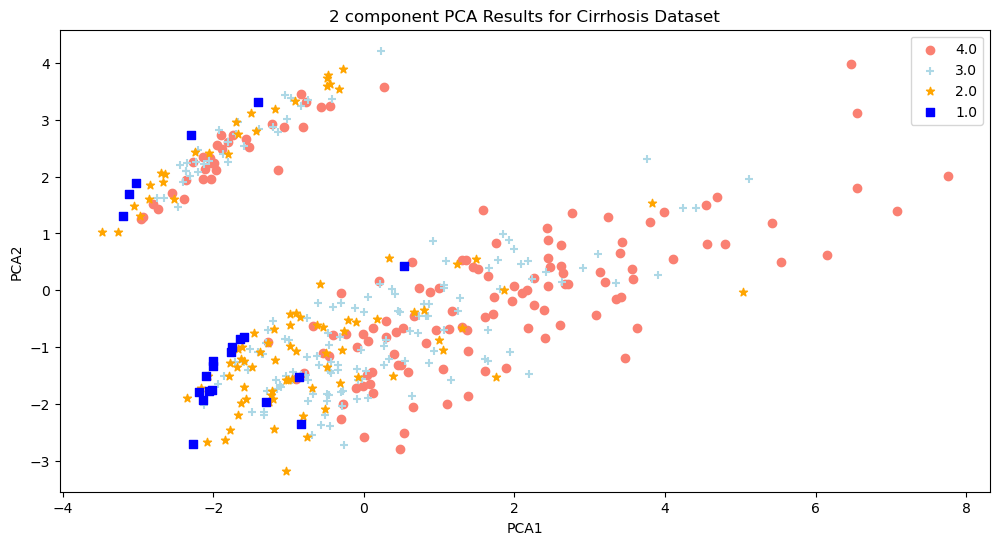

In [27]:
target_classes = data_raw[target_col].unique()
labels = data_raw[target_col]
plotPCA2(xpca, top_colors, markers, target_classes, labels)

**Observation**  
* There is obviously a batch effect in this dataset. 
* As described in the metadata, the dataset was assembled from 2 groups; 312 and 106. 
* It will be interesting to examine the samples that contribute to this batch effect.

In [28]:
pca = PCA(n_components=3)
pca.fit(scaled_data)
xpca = pca.transform(scaled_data)

In [29]:
xpca.shape

(406, 3)

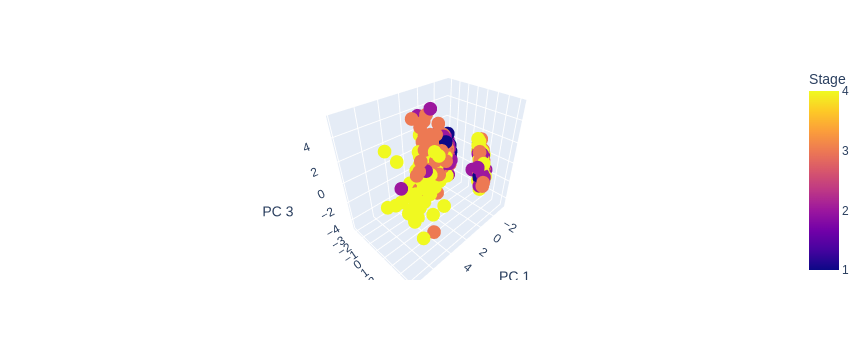

In [30]:
import plotly.express as px

pca_data = pd.concat([pd.DataFrame(xpca), data_raw[target_col]], axis=1)
fig = px.scatter_3d(
    pca_data,
    x=0,
    y=1,
    z=2,
    color=target_col,
    labels={"0": "PC 1", "1": "PC 2", "2": "PC 3"},
)
fig.show()

In [31]:
# Make a correlation matrix
data.corr()

N_Days    Status      Drug       Age       Sex   Ascites  \
N_Days         1.000000 -0.413809  0.129191 -0.139864 -0.004642  0.018531   
Status        -0.413809  1.000000  0.045447  0.189034  0.122200  0.191089   
Drug           0.129191  0.045447  1.000000 -0.157683  0.005137  0.718431   
Age           -0.139864  0.189034 -0.157683  1.000000  0.168208 -0.003882   
Sex           -0.004642  0.122200  0.005137  0.168208  1.000000  0.040118   
Ascites        0.018531  0.191089  0.718431 -0.003882  0.040118  1.000000   
Hepatomegaly  -0.012355  0.225559  0.709997 -0.052707  0.059854  0.774803   
Spiders       -0.009797  0.177810  0.665542 -0.114638 -0.041982  0.761555   
Edema         -0.319914  0.311154  0.049637  0.200344  0.032858  0.313555   
Bilirubin     -0.399896  0.429894  0.054229  0.006219 -0.028255  0.166082   
Cholesterol   -0.117219  0.157566  0.010432 -0.131812 -0.010101 -0.024844   
Albumin        0.435568 -0.258748  0.078046 -0.179320  0.029536 -0.075314   
Copper        -0.326846  0.341463  0.000034  0.054123  0.216273  0.101623   
Alk_Phos       0.133978  0.199295 -0.010460 -0.041716  0.028976  0.004854   
SGOT          -0.202393  0.259795  0.023989 -0.132325 -0.003252  0.042194   
Tryglicerides -0.129719  0.178078  0.004654  0.018450  0.044651  0.086739   
Platelets      0.173776 -0.100468  0.099868 -0.162977 -0.091805  0.003424   
Prothrombin   -0.115740  0.338885  0.035662  0.114097  0.073195  0.125352   
Stage         -0.261137  0.220288  0.053747  0.088075  0.001191  0.121963   

               Hepatomegaly   Spiders     Edema  Bilirubin  Cholesterol  \
N_Days            -0.012355 -0.009797 -0.319914  -0.399896    -0.117219   
Status             0.225559  0.177810  0.311154   0.429894     0.157566   
Drug               0.709997  0.665542  0.049637   0.054229     0.010432   
Age               -0.052707 -0.114638  0.200344   0.006219    -0.131812   
Sex                0.059854 -0.041982  0.032858  -0.028255    -0.010101   
Ascites            0.774803  0.761555  0.313555   0.166082    -0.024844   
Hepatomegaly       1.000000  0.764133  0.147793   0.163282     0.074352   
Spiders            0.764133  1.000000  0.206847   0.162471     0.035129   
Edema              0.147793  0.206847  1.000000   0.340706    -0.095084   
Bilirubin          0.163282  0.162471  0.340706   1.000000     0.340443   
Cholesterol        0.074352  0.035129 -0.095084   0.340443     1.000000   
Albumin           -0.073563 -0.047700 -0.340698  -0.317114    -0.055676   
Copper             0.132105  0.153551  0.241754   0.408388     0.123024   
Alk_Phos           0.062400  0.022340  0.022182   0.104652     0.140112   
SGOT               0.077004  0.077128  0.132641   0.395165     0.337282   
Tryglicerides      0.086329  0.054153  0.073023   0.374387     0.276828   
Platelets         -0.010888 -0.001593 -0.213056  -0.025212     0.156698   
Prothrombin        0.090773  0.124399  0.333883   0.308762    -0.025226   
Stage              0.250656  0.169883  0.198750   0.191874     0.009026   

                Albumin    Copper  Alk_Phos      SGOT  Tryglicerides  \
N_Days         0.435568 -0.326846  0.133978 -0.202393      -0.129719   
Status        -0.258748  0.341463  0.199295  0.259795       0.178078   
Drug           0.078046  0.000034 -0.010460  0.023989       0.004654   
Age           -0.179320  0.054123 -0.041716 -0.132325       0.018450   
Sex            0.029536  0.216273  0.028976 -0.003252       0.044651   
Ascites       -0.075314  0.101623  0.004854  0.042194       0.086739   
Hepatomegaly  -0.073563  0.132105  0.062400  0.077004       0.086329   
Spiders       -0.047700  0.153551  0.022340  0.077128       0.054153   
Edema         -0.340698  0.241754  0.022182  0.132641       0.073023   
Bilirubin     -0.317114  0.408388  0.104652  0.395165       0.374387   
Cholesterol   -0.055676  0.123024  0.140112  0.337282       0.276828   
Albumin        1.000000 -0.230096 -0.088322 -0.191561      -0.082440   
Copper        -0.230096  1.000000  0.18

(19.5, -0.5)

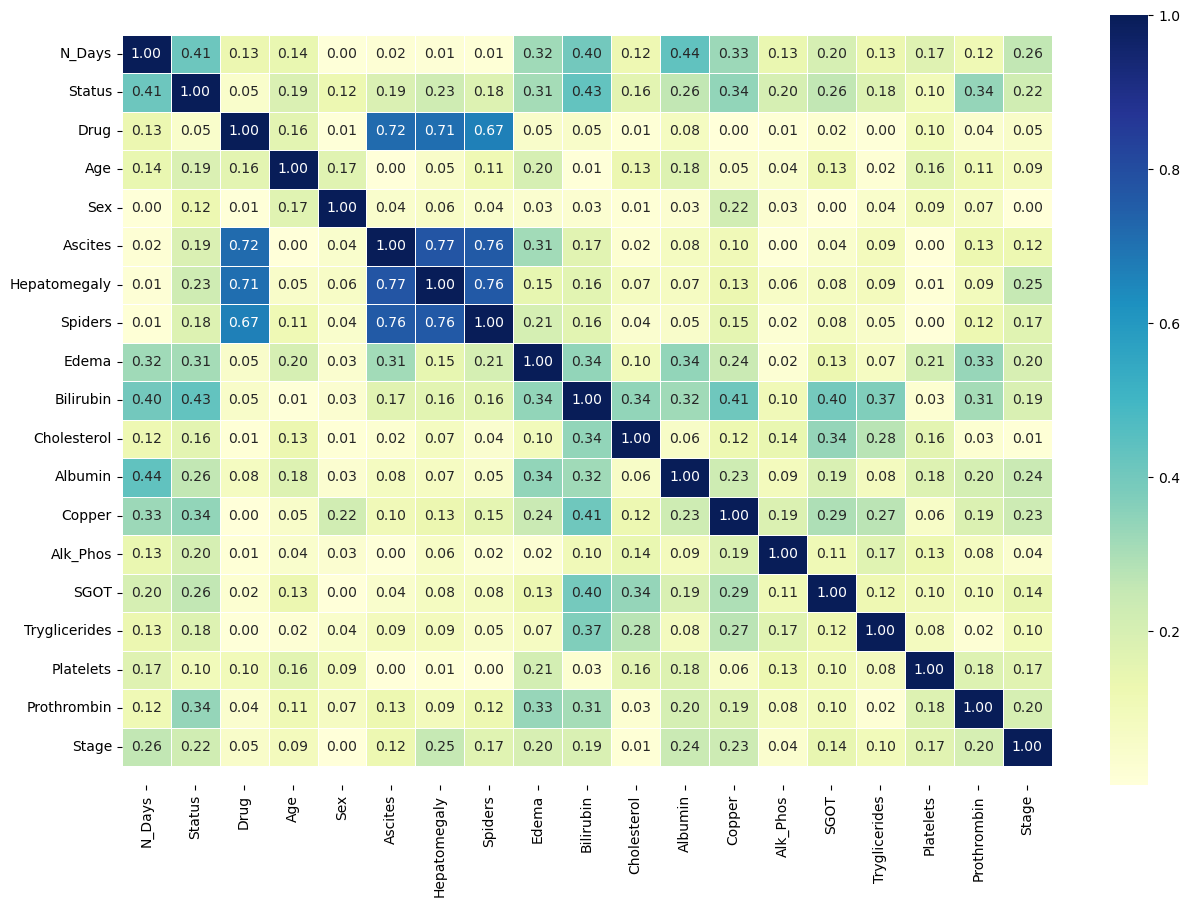

In [32]:
# Let's make our correlation matrix a little prettier
corr_matrix = data.corr().abs()
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corr_matrix, annot=True, linewidths=0.5, fmt=".2f", cmap="YlGnBu")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [33]:
corr_matrix.Stage

N_Days           0.261137
Status           0.220288
Drug             0.053747
Age              0.088075
Sex              0.001191
Ascites          0.121963
Hepatomegaly     0.250656
Spiders          0.169883
Edema            0.198750
Bilirubin        0.191874
Cholesterol      0.009026
Albumin          0.241971
Copper           0.232963
Alk_Phos         0.035841
SGOT             0.143235
Tryglicerides    0.100174
Platelets        0.166334
Prothrombin      0.200747
Stage            1.000000
Name: Stage, dtype: float64

**Observation**   
* Obviously some features have a strong correlation with the target while others such as Drug, Age and Cholesterol levels have a weak correlation.
* We will train models first on all features, then on a subset of features with a stronger correlation.

## 5. Modelling 
Here we will use sklearn and build machine learning models and train them to predict patient diagnosis of heart failure.

In [34]:
data.head()

N_Days  Status  Drug      Age  Sex  Ascites  Hepatomegaly  Spiders  Edema  \
0   400.0     3.0   1.0  21464.0  1.0      2.0           2.0      2.0    3.0   
1  4500.0     1.0   1.0  20617.0  1.0      1.0           2.0      2.0    1.0   
2  1012.0     3.0   1.0  25594.0  2.0      1.0           1.0      1.0    2.0   
3  1925.0     3.0   1.0  19994.0  1.0      1.0           2.0      2.0    2.0   
4  1504.0     2.0   2.0  13918.0  1.0      1.0           2.0      2.0    1.0   

   Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  Tryglicerides  \
0       14.5        261.0     2.60   156.0    1718.0  137.95          172.0   
1        1.1        302.0     4.14    54.0    7394.8  113.52           88.0   
2        1.4        176.0     3.48   210.0     516.0   96.10           55.0   
3        1.8        244.0     2.54    64.0    6121.8   60.63           92.0   
4        3.4        279.0     3.53   143.0     671.0  113.15           72.0   

   Platelets  Prothrombin  Stage  
0      190.0         12.2    4.0  
1      221.0         10.6    3.0  
2      151.0         12.0    4.0  
3      183.0         10.3    4.0  
4      136.0         10.9    3.0

In [35]:
# Split data into X and y
X = data.drop(target_col, axis=1).values

y = data[target_col].values

In [36]:
X

array([[4.00000000e+02, 3.00000000e+00, 1.00000000e+00, ...,
        1.72000000e+02, 1.90000000e+02, 1.22000000e+01],
       [4.50000000e+03, 1.00000000e+00, 1.00000000e+00, ...,
        8.80000000e+01, 2.21000000e+02, 1.06000000e+01],
       [1.01200000e+03, 3.00000000e+00, 1.00000000e+00, ...,
        5.50000000e+01, 1.51000000e+02, 1.20000000e+01],
       ...,
       [1.05500000e+03, 1.00000000e+00, 0.00000000e+00, ...,
        1.24702128e+02, 1.43000000e+02, 9.90000000e+00],
       [6.91000000e+02, 1.00000000e+00, 0.00000000e+00, ...,
        1.24702128e+02, 2.69000000e+02, 1.04000000e+01],
       [9.76000000e+02, 1.00000000e+00, 0.00000000e+00, ...,
        1.24702128e+02, 3.50000000e+02, 1.06000000e+01]])

In [37]:
scaled = StandardScaler()
scaled.fit(X)
X = scaled.transform(X)
X[:3]

array([[-1.37732234,  1.2330687 , -0.19256106,  0.77369416, -0.34863586,
         2.29526233,  1.08185931,  1.50023206,  3.52825846,  2.54382713,
        -0.56034778, -2.13015625,  0.78125401, -0.14127702,  0.31020238,
         0.8726621 , -0.70432219,  1.43870388],
       [ 2.36588293, -0.86599164, -0.19256106,  0.55260341, -0.34863586,
         0.33753858,  1.08185931,  1.50023206, -0.39632492, -0.47946829,
        -0.34862407,  1.51787271, -0.58439649,  2.88907961, -0.18209426,
        -0.67716695, -0.37653814, -0.12275016],
       [-0.81858048,  1.2330687 , -0.19256106,  1.85173993,  2.86832228,
         0.33753858, -0.21000798,  0.01463641,  1.56596677, -0.41178257,
        -0.99928717, -0.04556827,  1.50424545, -0.78292172, -0.53313018,
        -1.28602836, -1.11669566,  1.24352213]])

In [38]:
y[:20]

array([4., 3., 4., 4., 3., 3., 3., 3., 2., 4., 4., 4., 3., 4., 3., 3., 4.,
       4., 3., 4.])

In [39]:
# Split data into train and test sets
np.random.seed(42)
# Split into train & test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [40]:
y_test

array([4., 3., 3., 2., 2., 4., 3., 2., 4., 4., 2., 3., 1., 1., 2., 3., 4.,
       3., 4., 4., 2., 3., 3., 3., 4., 4., 4., 2., 2., 3., 4., 2., 4., 4.,
       3., 3., 3., 3., 4., 2., 3., 2., 2., 3., 1., 2., 3., 3., 1., 2., 3.,
       4., 4., 3., 4., 3., 4., 1., 4., 2., 1., 3., 2., 3., 4., 4., 3., 3.,
       4., 4., 3., 3., 3., 4., 2., 3., 3., 4., 3., 2., 4., 3.])

In [41]:
X_train.shape, X_test.shape

((324, 18), (82, 18))

Now we've got our data split into training(80%) and test(20%) sets, it's time to build a machine learning model.

We'll train it (find the patterns) on the training set.

And we'll test it (use the patterns) on the test set.

The small dataset makes it easier to perform many experiments. So, we're going to try 9 different machine learning models. 
1. Logistic Regression 
2. K-Nearest Neighbours Classifier
3. Random Forest Classifier
4. SVM Classifier
5. Naive Bayes, Gaussian 
6. Gradient Boosting
7. MLPClassifier
8. DecisionTreeClassifier
9. BaggingClassifier

In [42]:
# Models from Scikit-Learn
from sklearn.ensemble import (
    BaggingClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

In [43]:
# Put models in a dictionary
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVC": SVC(random_state=42),
    "NB Classifier": GaussianNB(),
    "Gradient Boost": GradientBoostingClassifier(random_state=42),
    "MLPClassifier": MLPClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "BaggingClassifier": BaggingClassifier(
        base_estimator=SVC(), n_estimators=100, random_state=42
    ),
}

# Create a function to fit and score models
def fit_and_score(
    models, X_train, X_test, y_train, y_test, X=None, y=None, cv=5, scoring="accuracy"
):
    """
    Fits and evaluates given machine learning models.
    models : a dict of differetn Scikit-Learn machine learning models
    X_train : training data (no labels)
    X_test : testing data (no labels)
    y_train : training labels
    y_test : test labels
    X: full dataset inputs
    y: full dataset labels
    """
    # Set random seed
    np.random.seed(42)
    # Make a dictionary to keep model scores
    model_scores = {"model": [], scoring: [], "cv-score": []}
    # Loop through models
    for name, model in models.items():
        # cross validation
        cv_score = cross_val_score(model, X, y, cv=cv, scoring=scoring)
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores["model"].append(name)
        model_scores[scoring].append(model.score(X_test, y_test))

        model_scores["cv-score"].append(
            f"{round(cv_score.mean(),3)} ± {round(cv_score.std(),3)}"
        )

    return pd.DataFrame(model_scores)

In [44]:
model_scores = fit_and_score(
    models=models,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    X=X,
    y=y,
    cv=cv,
    scoring="accuracy",
)

model_scores

model  accuracy       cv-score
0     Logistic Regression  0.439024  0.446 ± 0.075
1                     KNN  0.451220  0.446 ± 0.076
2           Random Forest  0.414634   0.426 ± 0.04
3                     SVC  0.426829    0.5 ± 0.073
4           NB Classifier  0.219512  0.234 ± 0.094
5          Gradient Boost  0.426829  0.431 ± 0.084
6           MLPClassifier  0.439024  0.478 ± 0.068
7  DecisionTreeClassifier  0.378049  0.379 ± 0.059
8       BaggingClassifier  0.439024   0.51 ± 0.054

In [45]:
data.columns

Index(['N_Days', 'Status', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly',
       'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage'],
      dtype='object')

### Feature Selection

The following columns will be removed from the dataset
* Drug
* Sex
* Age
* Cholesterol
* Alk_Phos

In [46]:
removed_columns = ["Drug", "Sex", "Age", "Cholesterol", "Alk_Phos"]

X = data.drop(removed_columns + ["Stage"], axis=1).values

In [47]:
X.shape

(406, 13)

In [48]:
# from sklearn.feature_selection import SelectKBest, chi2

# # Split data into train and test sets
# np.random.seed(42)
# # Split into train & test set
# X_new = SelectKBest(k=10).fit_transform(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [49]:
model_scores = fit_and_score(
    models=models,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    X=X,
    y=y,
    cv=cv,
    scoring="accuracy",
)

model_scores

model  accuracy       cv-score
0     Logistic Regression  0.402439  0.409 ± 0.068
1                     KNN  0.304878  0.355 ± 0.052
2           Random Forest  0.390244  0.431 ± 0.056
3                     SVC  0.365854  0.419 ± 0.045
4           NB Classifier  0.353659  0.335 ± 0.078
5          Gradient Boost  0.353659  0.411 ± 0.057
6           MLPClassifier  0.341463   0.343 ± 0.05
7  DecisionTreeClassifier  0.439024  0.407 ± 0.077
8       BaggingClassifier  0.365854  0.421 ± 0.045

### Try Removing Missing Values
Here, we will not fill missing values but completely remove them and see how that affects model performance.

In [50]:
data = pd.read_csv("cirrhosis.csv")
data.drop("ID", axis=1, inplace=True)

In [51]:
data = data.dropna()

In [52]:
for column in catCols:
    data[column] = data[column].astype("category").cat.codes + 1

In [53]:
X = data.drop(["Stage"], axis=1).values
y = data["Stage"].values

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [55]:
model_scores = fit_and_score(
    models=models,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    X=X,
    y=y,
    cv=cv,
    scoring="accuracy",
)

model_scores

model  accuracy       cv-score
0     Logistic Regression  0.482143  0.512 ± 0.103
1                     KNN  0.392857  0.435 ± 0.075
2           Random Forest  0.517857  0.511 ± 0.089
3                     SVC  0.553571   0.483 ± 0.07
4           NB Classifier  0.392857  0.362 ± 0.091
5          Gradient Boost  0.428571  0.467 ± 0.082
6           MLPClassifier  0.464286  0.384 ± 0.093
7  DecisionTreeClassifier  0.446429  0.373 ± 0.087
8       BaggingClassifier  0.553571   0.483 ± 0.07

Still bad results

### Model Comparison

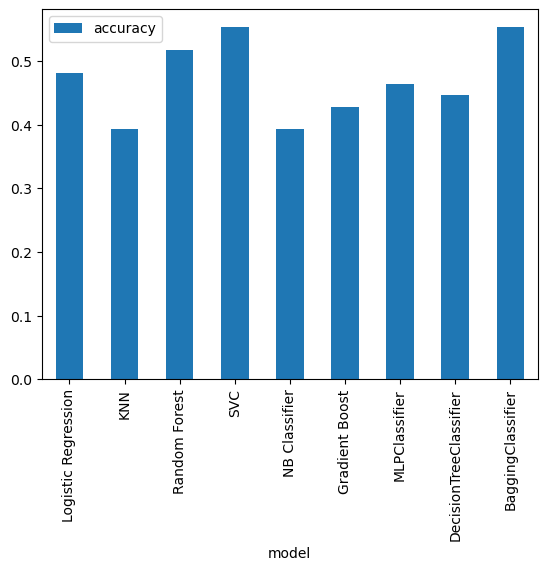

In [56]:
model_scores.plot.bar(x="model", y="accuracy");

### Classification Report

In [57]:
clf = SVC()
clf.fit(X_train, y_train)
y_preds = clf.predict(X_test)

In [58]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.00      0.00      0.00        11
         3.0       0.53      0.87      0.66        23
         4.0       0.61      0.52      0.56        21

    accuracy                           0.55        56
   macro avg       0.28      0.35      0.30        56
weighted avg       0.45      0.55      0.48        56



Even our machine learning model cannot predict the earlier stages of cirrhosis. Well, we cannot blame it since we fed it gabbage data.

What if we remove stage 1 and stage 2, will the model perform better in stage 3 and 4? Let's find out.

In [59]:
data = data[data.Stage != 1.0]
data = data[data.Stage != 2.0]

In [60]:
data.shape

(205, 19)

In [61]:
X = data.drop(["Stage"], axis=1).values
y = data["Stage"].values

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [63]:
model_scores = fit_and_score(
    models=models,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    X=X,
    y=y,
    cv=cv,
    scoring="accuracy",
)

model_scores

model  accuracy       cv-score
0     Logistic Regression  0.609756  0.659 ± 0.075
1                     KNN  0.512195   0.616 ± 0.13
2           Random Forest  0.560976  0.708 ± 0.059
3                     SVC  0.707317    0.646 ± 0.1
4           NB Classifier  0.707317  0.687 ± 0.099
5          Gradient Boost  0.585366  0.703 ± 0.067
6           MLPClassifier  0.341463  0.526 ± 0.078
7  DecisionTreeClassifier  0.463415   0.63 ± 0.092
8       BaggingClassifier  0.682927  0.655 ± 0.101

The model performance is much better now, but still not quite useful

Removing some features produce worse results in almost every model. The dataset set has serious problems such as class imbalance, many missing values, and batch effect. I think it will be wise to find a better dataset before working on the models.

### Separating the Batches

In [64]:
data = pd.read_csv("cirrhosis.csv")
data.drop("ID", axis=1, inplace=True)
data_raw = data.copy()

In [65]:
for column in catCols:
    data[column] = data[column].astype("category").cat.codes + 1

In [66]:
from sklearn.impute import SimpleImputer

# build an imputer with mean imputation
SI = SimpleImputer(strategy="mean")

# get numeric columns
data_numeric = data.drop(target_col, axis=1).select_dtypes(exclude=["int8"])

# impute numeric data
data_numeric = pd.DataFrame(
    SI.fit_transform(data_numeric), columns=data_numeric.columns
)
# update data
for column in data_numeric.columns:
    data[column] = data_numeric[column]

# build an imputer with median imputation for categorical variables
SI = SimpleImputer(strategy="median")

# get categorical columns
data_categorical = data.drop(target_col, axis=1).select_dtypes(["int8"])

# impute categorical data
data_categorical = pd.DataFrame(
    SI.fit_transform(data_categorical), columns=data_categorical.columns
)
# update data
for column in data_categorical.columns:
    data[column] = data_categorical[column]

data.dropna(axis=0, inplace=True)
data_raw = data_raw.loc[data.index]
data = data.reset_index()
data.drop("index", axis=1, inplace=True)

In [67]:
data = data.astype(float)

In [69]:
def plotPCA2(xpca, top_colors, markers, target_classes, labels):
    PC1 = 0
    PC2 = 1
    plt.figure(figsize=(12, 6))
    colors = top_colors[: len(target_classes)]
    axes = []

    for i, class_ in enumerate(target_classes):
        axes.append(
            plt.scatter(
                xpca[labels == class_][:, PC1],
                xpca[labels == class_][:, PC2],
                c=colors[i],
                marker=markers[i],
            )
        )

    x = xpca[:, PC1]
    y = 0.7 * x + 2
    axes.append(plt.plot(x, y))
    # target_classes.append("Line")
    # Add some helpful info
    plt.title(f"2 component PCA Results for {case_study} Dataset")
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.legend(axes, target_classes);

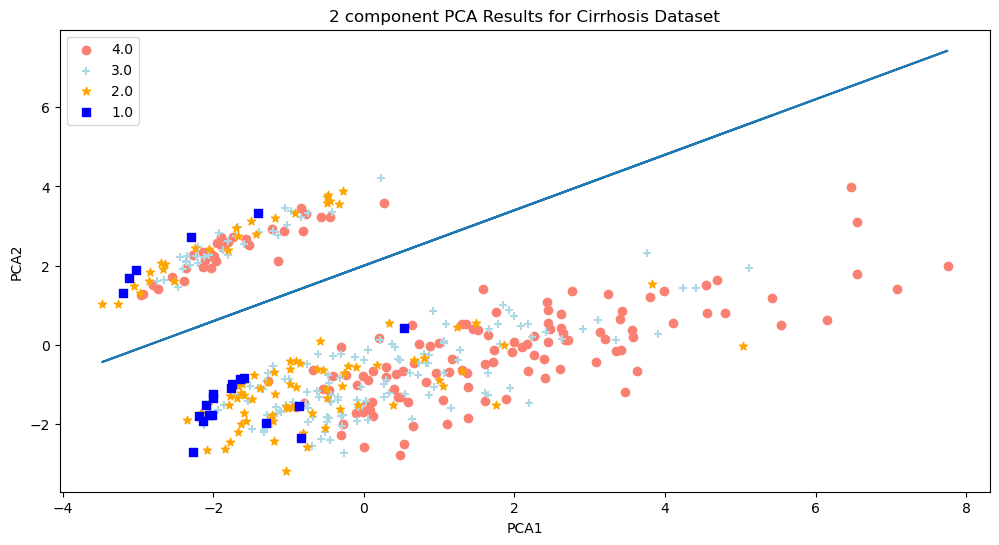

In [70]:
plotPCA2(xpca, top_colors, markers, target_classes, labels)

In [71]:
small_cluster = []

x = xpca[:, 0]
y2 = 0.7 * x + 2

for i in range(len(xpca)):
    if xpca[i, 1] > y2[i]:
        small_cluster.append(i)

In [72]:
small_cluster[:20]

[312,
 313,
 314,
 315,
 316,
 317,
 318,
 319,
 320,
 321,
 322,
 323,
 324,
 325,
 326,
 327,
 328,
 329,
 330,
 331]

In [76]:
from sklearn.preprocessing import StandardScaler

scaled = StandardScaler()
scaled.fit(data)
scaled_data = scaled.transform(data)

In [77]:
scaled_data = scaled_data[small_cluster]

In [78]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(scaled_data)
xpca = pca.transform(scaled_data)

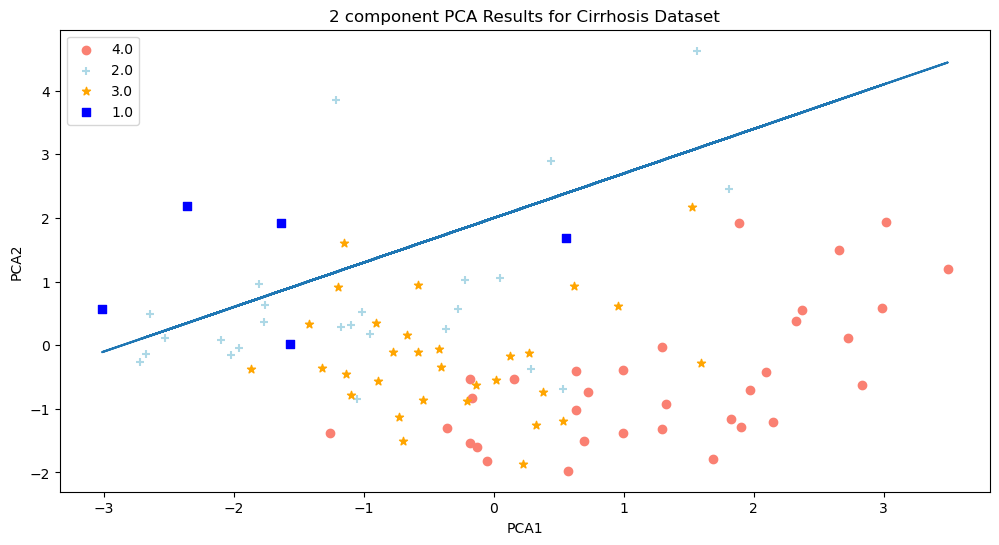

In [79]:
target_classes = new_data[target_col].unique()
labels = new_data[target_col]
plotPCA2(xpca, top_colors, markers, target_classes, labels)

In [80]:
data = data.drop(small_cluster, axis=0)

In [81]:
# data = data[data.Stage != 1.0]
# data = data[data.Stage != 2.0]

In [82]:
data.shape

(318, 19)

In [83]:
X = data.drop(["Stage"], axis=1).values
y = data["Stage"].values

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
model_scores = fit_and_score(
    models=models,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    X=X,
    y=y,
    cv=cv,
    scoring="accuracy",
)

model_scores

model  accuracy       cv-score
0     Logistic Regression  0.390625  0.488 ± 0.081
1                     KNN  0.437500  0.425 ± 0.072
2           Random Forest  0.421875  0.475 ± 0.096
3                     SVC  0.390625  0.459 ± 0.064
4           NB Classifier  0.406250   0.38 ± 0.095
5          Gradient Boost  0.437500  0.503 ± 0.079
6           MLPClassifier  0.390625  0.346 ± 0.068
7  DecisionTreeClassifier  0.296875  0.412 ± 0.085
8       BaggingClassifier  0.406250  0.469 ± 0.055

Separating the batches did not solve anything unfortunately.